In [5]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [6]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# 1) Data Gathering and Analysis

In [7]:
df = pd.read_csv("/content/sample_data/dataset.csv", skipinitialspace=True, engine="python")
df.sample(frac=1).head(25)

,Number,Category,Action_needed,Question,Subcategory,Action,Time,Sentence
416,417,weather,1,1,place,none,now,What temperature is it in Brussels?
209,210,direction,1,1,home,none,minute,Do I have to travel far when I want to go home...
380,381,other,1,1,none,none,none,How tall is the tallest human?
168,169,openapp,0,0,none,none,now,Don't open up an app.
641,642,coffeemachine,0,0,kitchen,none,now,Don't give me any coffee.
360,361,other,1,1,none,none,none,Which players are in the premier league?
203,204,direction,1,1,myplace,none,now,When do the busses departure?
9,10,lights,1,0,bathroom,on,now,Turn on the light in the bathroom.
19,20,lights,1,0,diningroom,off,now,Turn the light off in the dining room.
515,516,heating,1,0,attic,off,now,It is hot in the attic.


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Number         663 non-null    int64 
 1   Category       663 non-null    object
 2   Action_needed  663 non-null    int64 
 3   Question       663 non-null    int64 
 4   Subcategory    663 non-null    object
 5   Action         663 non-null    object
 6   Time           663 non-null    object
 7   Sentence       663 non-null    object
dtypes: int64(3), object(5)
memory usage: 41.6+ KB


In [9]:
df.columns

Index(['Number', 'Category', 'Action_needed', 'Question', 'Subcategory',
       'Action', 'Time', 'Sentence'],
      dtype='object')

In [10]:
# Number is an index, therefore not needed
df = df.drop(columns="Number")
df.shape

(663, 7)

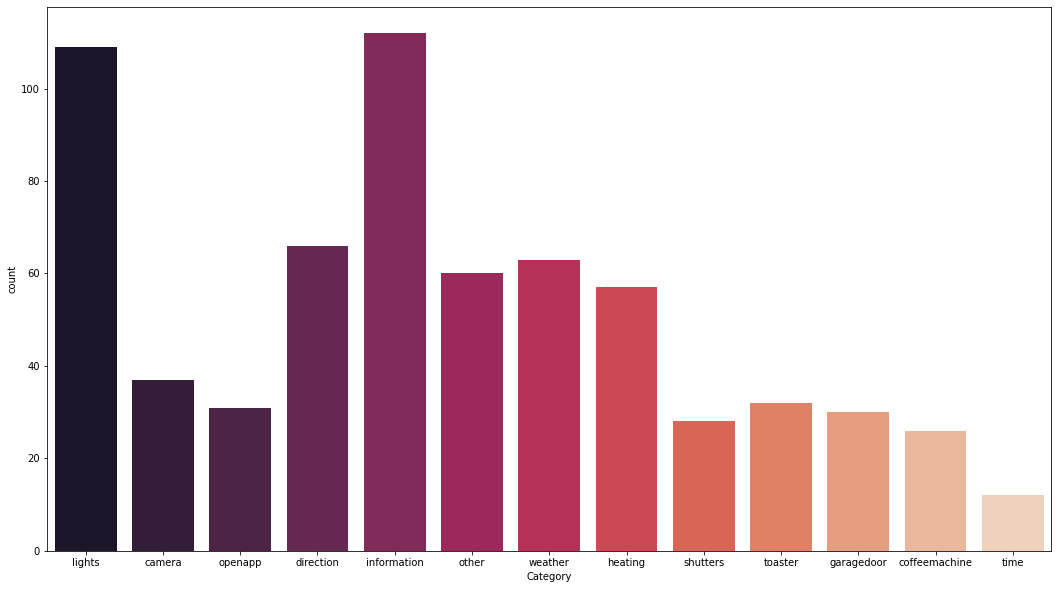

In [11]:
plt.figure(figsize=(18,10))
sns.countplot(x="Category", palette="rocket", data=df)

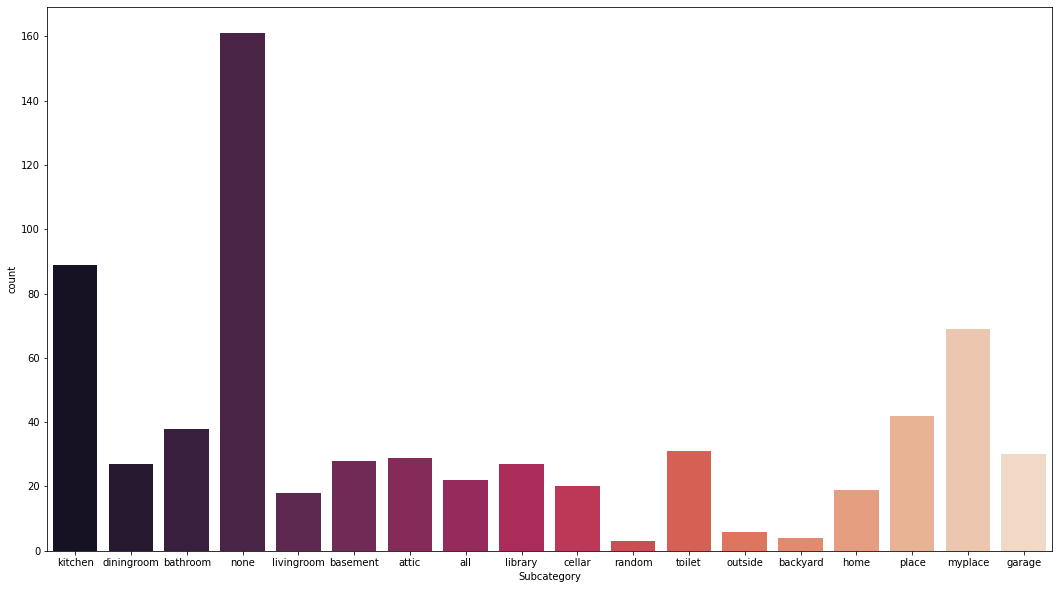

In [12]:
plt.figure(figsize=(18,10))
sns.countplot(x="Subcategory", palette="rocket", data=df)

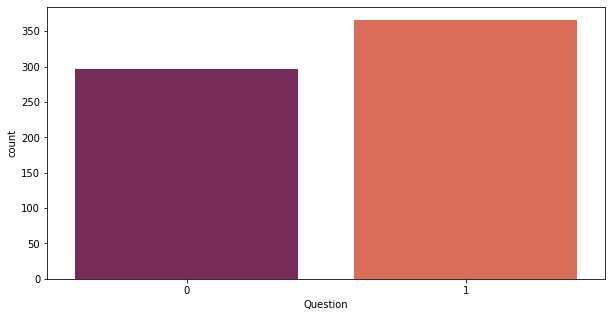

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(x="Question", palette="rocket", data=df)

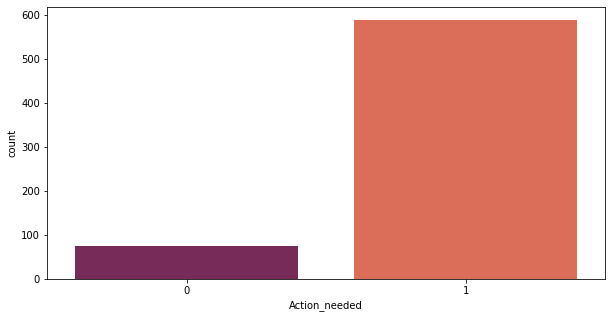

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(x="Action_needed", palette="rocket", data=df)

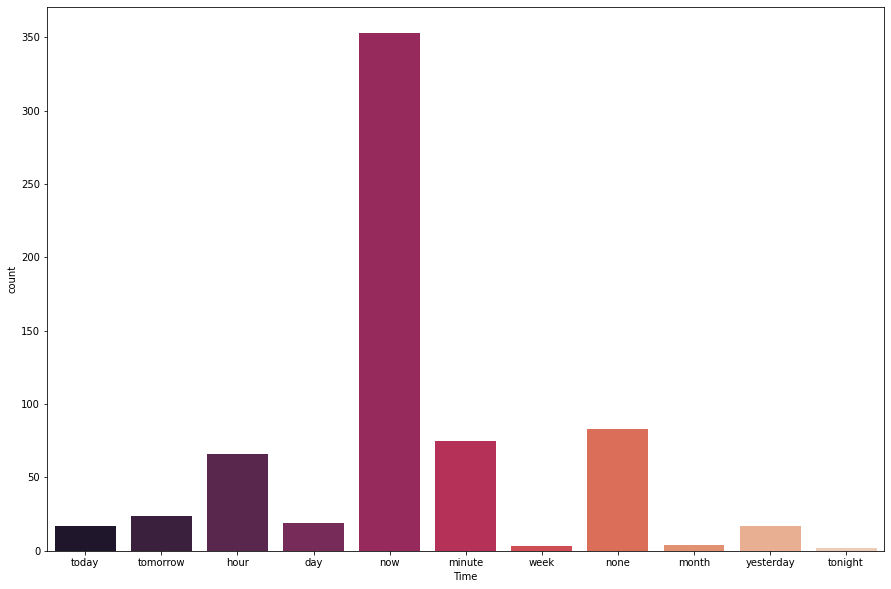

In [15]:
plt.figure(figsize=(15,10))
sns.countplot(x="Time", palette="rocket", data=df)

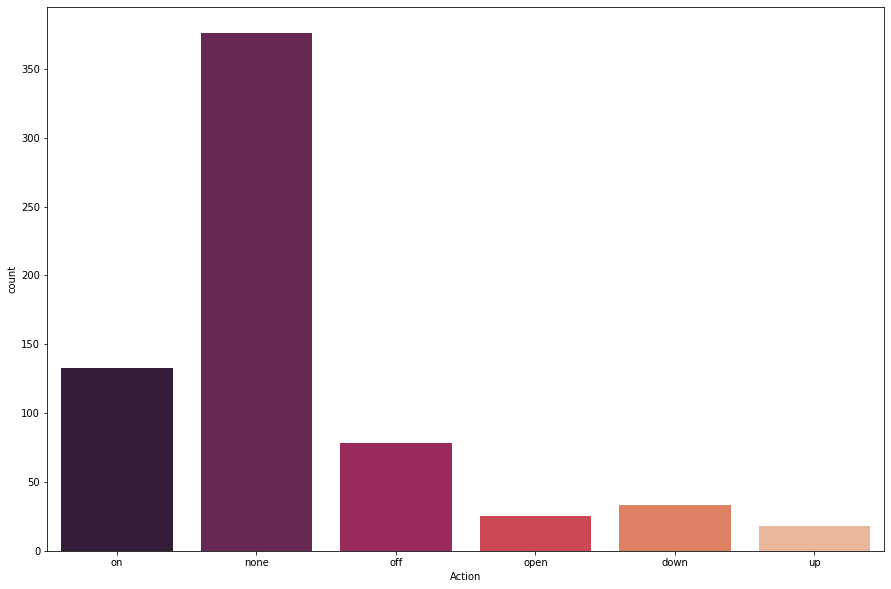

In [16]:
plt.figure(figsize=(15,10))
sns.countplot(x="Action", palette="rocket", data=df)

# 2) Data Preparation

In [17]:
import nltk
from nltk import word_tokenize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import itertools
import math

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
# calculates how often the word appears in the sentence
def term_frequency(word, sentence):
    return sentence.split().count(word)

# calculates how often the word appears in the entire vocabulary
def document_frequency(word):
    return vocabulary.count(word)

# will make sure that unimportant words such as "and" that occur often will have lower weights
# log taken to avoid exploding of IDF with words such as 'is' that can occur a lot
def inverse_document_frequency(word):
    return math.log(len(vocabulary) / (document_frequency(word) + 1))

# get term frequency inverse document frequency value
def calculate_tfidf(word, sentence):
    return term_frequency(word, sentence) * inverse_document_frequency(word)

# get one-hot encoded vectors for the targets
def one_hot_class_vector(uniqueclasses, w):
    emptyvector = [0 for i in range(len(uniqueclasses))]
    emptyvector[uniqueclasses.index(w)] = 1
    return emptyvector

# get one-hot encoded vectors for the words
def one_hot_vector(w):
    emptyvector = [0 for i in range(len(vocabulary))]
    emptyvector[vocabulary.index(w)] = 1
    return emptyvector

# get one-hot encdoded sentence vector
def sentence_vector(sentence, tfidf=False):
    tokenizedlist = word_tokenize(sentence.lower())
    sentencevector = [0 for i in range(len(vocabulary))]
    count = 0

    for word in tokenizedlist:
        if word in vocabulary:
            count = count + 1
            if tfidf:
                sentencevector = [x + y for x, y in zip(sentencevector, [e * calculate_tfidf(word, sentence) for e in one_hot_vector(word)])] 
            else:
                sentencevector = [x + y for x, y in zip(sentencevector, one_hot_vector(word))]

    if count == 0:
        return sentencevector
    else:
        return [(el / count) for el in sentencevector]

In [19]:
sentences = df['Sentence']
categories = df['Category']
subcategories = df['Subcategory']
actions = df['Action']
action_needed = df['Action_needed']
question = df['Question']
time_col = df['Time']

uniquecategories = list(set(categories))
uniquesubcategories = list(set(subcategories))
uniqueactions = list(set(actions))
uniqueaction_needed = [1, 0]
uniquequestion = [1, 0]
uniquetime = list(set(time_col))

mergesentences = list(itertools.chain.from_iterable(
    [word_tokenize(sentence.lower()) for sentence in sentences]))
vocabulary = list(set(mergesentences))
print(vocabulary)

['readings', 'be', '4', 'basement', 'mean', 'was', 'eighteen', 'stop', 'minute', 'players', 'from', 'dogs', 'something', 'brussels', 'animal', 'flow', 'cut', 'ok', 'refrigerator', 'has', 'rises', 'amount', 'if', 'religions', 'heating', 'weeks', 'week', 'or', 'diningroom', 'shooting', 'viewing', 'library', 'coming', 'hailing', 'which', 'electricity', 'go', 'close', 'certain', '6', 'earth', 'update', '8', 'fourteen', 'control', 'machine', 'cofeemachine', 'this', 'and', 'running', 'backyard', 'clouds', 'hot', 'move', 'bright', 'help', 'app', 'possible', 'toaster', 'getting', 'continent', 'hit', 'responds', 'way', 'tell', 'door', 'te', '15', 'outdoor', 'few', 'live', 'above', 'know', 'find', 'cloudy', 'down', 'google', 'open', 'mouth', 'foggy', 'one', 'long', 'life', 'where', 'special', 'the', 'when', 'attic', 'facebook', 'think', "n't", 'transport', 'leuven', 'sad', 'say', 'belgium', 'falls', 'reading', 'did', 'universe', 'you', 'strange', 'turn', 'maps', '.', 'of', 'potatoes', 'pixels', 

In [20]:
categoryvectors = [cv.index(1) for cv in [one_hot_class_vector(uniquecategories, w) for w in categories]]
subcategoryvectors = [cv.index(1) for cv in [one_hot_class_vector(uniquesubcategories, w) for w in subcategories]]
actionvectors = [cv.index(1) for cv in [one_hot_class_vector(uniqueactions, w) for w in actions]]
action_neededvectors = [cv.index(1) for cv in [one_hot_class_vector(uniqueaction_needed, w) for w in action_needed]]
questionvectors = [cv.index(1) for cv in [one_hot_class_vector(uniquequestion, w) for w in question]]
timevectors = [cv.index(1) for cv in [one_hot_class_vector(uniquetime, w) for w in time_col]]

sentencevectors = [sentence_vector(sentence) for sentence in sentences]
sentencevectorstfidf = [sentence_vector(sentence, True) for sentence in sentences]


In [21]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(sentencevectors, categoryvectors, test_size=0.25, random_state=42)
X_train_cat_tfidf, X_test_cat_tfidf, y_train_cat_tfidf, y_test_cat_tfidf = train_test_split(sentencevectorstfidf, categoryvectors, test_size=0.25, random_state=42)
X_train_subcat, X_test_subcat, y_train_subcat, y_test_subcat = train_test_split(sentencevectors, subcategoryvectors, test_size=0.25, random_state=42)
X_train_action, X_test_action, y_train_action, y_test_action = train_test_split(sentencevectors, actionvectors, test_size=0.25, random_state=42)
X_train_action_needed, X_test_action_needed, y_train_action_needed, y_test_action_needed = train_test_split(sentencevectors, action_neededvectors, test_size=0.25, random_state=42)
X_train_question, X_test_question, y_train_question, y_test_question = train_test_split(sentencevectors, questionvectors, test_size=0.25, random_state=42)
X_train_time, X_test_time, y_train_time, y_test_time = train_test_split(sentencevectors, timevectors, test_size=0.25, random_state=42)

In [22]:
ALL_COLS = df.columns.drop("Sentence")
ENCODING_COLS = ["Category", "Subcategory", "Action", "Time"]

df_label_encoded = df.copy()

le = {}
for i in ENCODING_COLS:
  le[i] = preprocessing.LabelEncoder()
  df_label_encoded[i] = le[i].fit_transform(df_label_encoded[i])

df_label_encoded = shuffle(df_label_encoded)

In [23]:
df_train = df_label_encoded.iloc[:int(df_label_encoded.shape[0] * 0.90), :].copy()
df_test = df_label_encoded.iloc[int(df_label_encoded.shape[0] * 0.90):, :].copy()

In [24]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32

train_dataset = {}
test_dataset = {}
for c in ALL_COLS:
  train_dataset[c] = tf.data.Dataset.from_tensor_slices((df_train["Sentence"].to_numpy(), tf.one_hot(df_train[c], df_label_encoded[c].max()))).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
  test_dataset[c] = tf.data.Dataset.from_tensor_slices((df_test["Sentence"].to_numpy(), tf.one_hot(df_test[c], df_label_encoded[c].max()))).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

In [25]:
encoder = {}
for c in ALL_COLS:
  encoder[c] = tf.keras.layers.TextVectorization(max_tokens=1000)
  encoder[c].adapt(train_dataset[c].map(lambda text, label: text), steps=df.shape[0])

vocabulary_tf = np.array(encoder["Question"].get_vocabulary())
vocabulary_tf[:20]

array(['', '[UNK]', 'the', 'in', 'is', 'it', 'you', 'me', 'turn', 'on',
       'can', 'what', 'i', 'room', 'minutes', 'hour', 'an', 'do', 'light',
       'a'], dtype='<U13')

# 3) Training Models

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score
from numpy import random

random.seed(2020)

In [27]:
def train_fit(model_name, model, X, y, X_test, y_test):
    model.fit(X, y)
    y_preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_preds)
    print(f"{model_name}: {accuracy}")
    return model

## 3.1) No neural networks.


For comparing.

In [28]:
#random forest, different trees, majority decides
random_forest_model = RandomForestClassifier()
random_forest_model = train_fit("RandomForestClassifier", random_forest_model, X_train_cat, y_train_cat, X_test_cat, y_test_cat)

RandomForestClassifier: 0.8855421686746988


In [29]:
#svc liniar (support vector classification)
svc_model_linear = SVC(kernel='linear', decision_function_shape='ovo')
svc_model_linear = train_fit("SVC (linear)", svc_model_linear, X_train_cat, y_train_cat, X_test_cat, y_test_cat)

SVC (linear): 0.5421686746987951


In [30]:
#svc rbf (radial basis function), popular and default
svc_model_rbf = SVC(kernel='rbf', decision_function_shape='ovo')
svc_model_rbf = train_fit("SVC (rbf)", svc_model_rbf, X_train_cat, y_train_cat, X_test_cat, y_test_cat)

SVC (rbf): 0.8674698795180723


In [31]:
#boosted trees, adds trees in order to minimize loss
xgb_model = xgb.XGBClassifier()
xgb_model = train_fit("XGBClassifier", xgb_model, np.array(X_train_cat), np.array(y_train_cat), X_test_cat, y_test_cat)

XGBClassifier: 0.8975903614457831


In [32]:
#gradient boosting decision trees, similar to xgb, different alogrithm behind
lgbm_model = lgb.LGBMClassifier()
lgbm_model = train_fit("LGBMClassifier", lgbm_model, X_train_cat, y_train_cat, X_test_cat, y_test_cat)

LGBMClassifier: 0.7168674698795181


## 3.2) Neural Networks.

In [33]:
#mlp (multi-layer perception)
mlp_model = MLPClassifier()
mlp_model = train_fit("MLPClassifier", mlp_model, X_train_cat, y_train_cat, X_test_cat, y_test_cat)

MLPClassifier: 0.9096385542168675


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [34]:
model_rnn = {}
history = {}

In [40]:
model_rnn["Question"] = tf.keras.Sequential([
    encoder["Question"],
    tf.keras.layers.Embedding(
        input_dim=len(vocabulary_tf),
        output_dim=8,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [41]:
model_rnn["Question"].compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [42]:
history["Question"] = model_rnn["Question"].fit(train_dataset["Question"], epochs=10,
                    validation_data=test_dataset["Question"],
                    steps_per_epoch=500,
                    validation_steps=10)

Epoch 1/10
500/500 [==============================] - 28s 39ms/step - loss: 0.6670 - accuracy: 0.5539 - val_loss: 0.6112 - val_accuracy: 0.5451
Epoch 2/10
500/500 [==============================] - 9s 18ms/step - loss: 0.4950 - accuracy: 0.6637 - val_loss: 0.3181 - val_accuracy: 0.8541
Epoch 3/10
500/500 [==============================] - 9s 18ms/step - loss: 0.2537 - accuracy: 0.8895 - val_loss: 0.1765 - val_accuracy: 0.9099
Epoch 4/10
500/500 [==============================] - 9s 18ms/step - loss: 0.1429 - accuracy: 0.9442 - val_loss: 0.1377 - val_accuracy: 0.9099
Epoch 5/10
500/500 [==============================] - 9s 18ms/step - loss: 0.0945 - accuracy: 0.9627 - val_loss: 0.1202 - val_accuracy: 0.9099
Epoch 6/10
500/500 [==============================] - 10s 21ms/step - loss: 0.0695 - accuracy: 0.9697 - val_loss: 0.1080 - val_accuracy: 0.9099
Epoch 7/10
500/500 [==============================] - 9s 18ms/step - loss: 0.0520 - accuracy: 0.9828 - val_loss: 0.1007 - val_accuracy: 0.89

In [46]:
model_rnn["Category"] = tf.keras.Sequential([
    encoder["Category"],
    tf.keras.layers.Embedding(
        input_dim=len(vocabulary_tf),
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(12)
])

In [47]:
model_rnn["Category"].compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [48]:
history["Category"] = model_rnn["Category"].fit(train_dataset["Category"], epochs=20,
                    validation_data=test_dataset["Category"],
                    steps_per_epoch=1000,
                    validation_steps=10)

Epoch 1/20
1000/1000 [==============================] - 33s 21ms/step - loss: 0.3920 - accuracy: 0.1779 - val_loss: 0.2848 - val_accuracy: 0.0644
Epoch 2/20
1000/1000 [==============================] - 18s 18ms/step - loss: 0.2580 - accuracy: 0.1813 - val_loss: 0.2656 - val_accuracy: 0.0644
Epoch 3/20
1000/1000 [==============================] - 18s 18ms/step - loss: 0.2357 - accuracy: 0.2511 - val_loss: 0.2309 - val_accuracy: 0.3519
Epoch 4/20
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1817 - accuracy: 0.4575 - val_loss: 0.1850 - val_accuracy: 0.4979
Epoch 5/20
1000/1000 [==============================] - 19s 19ms/step - loss: 0.1213 - accuracy: 0.6546 - val_loss: 0.1446 - val_accuracy: 0.5708
Epoch 6/20
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0753 - accuracy: 0.7904 - val_loss: 0.1161 - val_accuracy: 0.6695
Epoch 7/20
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0483 - accuracy: 0.8557 - val_loss: 0.1094 -

# 4) Improvements

The liniar support vector machine with an optimized cost appears to be the best in the no NN category, we will use it as the base of our comparison.

In [49]:
# tweak the cost
svc_linear_cost_model = SVC(kernel='linear', decision_function_shape='ovo', C=52)
svc_linear_cost_model = train_fit("SVC (linear) + cost", svc_linear_cost_model, X_train_cat, y_train_cat, X_test_cat, y_test_cat)

SVC (linear) + cost: 0.9096385542168675


At the cost of more time spent training, increasing the maximum iterations of our mlp model also increases its accuracy, as long as we don't overdo it and overfit the model.

In [50]:
# increased max iterations
mlp_max_iter_model = MLPClassifier(max_iter=10000)
mlp_max_iter_model = train_fit("MLPClassifier", mlp_max_iter_model, X_train_cat, y_train_cat, X_test_cat, y_test_cat)

MLPClassifier: 0.9156626506024096


A popular choice in NLP is to use tf-idf data, that takes into account the frequency of the words when setting the weights.

This is better used in big sentences, where words (especially the unimportant ones like: the, in, etc.) are more likely to repeat.

With our short sentences, it comes as unsurprising that we get a poorer performance than with the normal model.

In [51]:
# tf-idf (term frequency-inverse document frequency), performs poorly because of the small length of the sentences
mlp_max_iter_model_tfidf = MLPClassifier(max_iter=10000)
mlp_max_iter_model_tfidf = train_fit("MLPClassifier", mlp_max_iter_model_tfidf, X_train_cat_tfidf, y_train_cat_tfidf, X_test_cat_tfidf, y_test_cat_tfidf)

MLPClassifier: 0.8554216867469879


Gave it more tensors. Should not overfit yet.

4x faster (same relative results with 2x less epochs and steps) and better accuracy.

I am sure that it is not the best performance you can get out of an rnn, but a 90% acc is good enough for me. Besides, it might not be the best 

In [52]:
for c in ALL_COLS:
  print("\nModel: ", c, "\n")
  model_rnn[c] = tf.keras.Sequential([
    encoder[c],
    tf.keras.layers.Embedding(
        input_dim=len(vocabulary_tf),
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(df_label_encoded[c].max())
  ])

  model_rnn[c].compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
  
  history[c] = model_rnn[c].fit(train_dataset[c], epochs=10,
                    validation_data=test_dataset[c],
                    steps_per_epoch=500,
                    validation_steps=10)


Model:  Category 

Epoch 1/10
500/500 [==============================] - 23s 28ms/step - loss: 0.4358 - accuracy: 0.1127 - val_loss: 0.3046 - val_accuracy: 0.0644
Epoch 2/10
500/500 [==============================] - 11s 21ms/step - loss: 0.2694 - accuracy: 0.1799 - val_loss: 0.2764 - val_accuracy: 0.0644
Epoch 3/10
500/500 [==============================] - 10s 21ms/step - loss: 0.2528 - accuracy: 0.1843 - val_loss: 0.2611 - val_accuracy: 0.0644
Epoch 4/10
500/500 [==============================] - 11s 22ms/step - loss: 0.2334 - accuracy: 0.2813 - val_loss: 0.2269 - val_accuracy: 0.3433
Epoch 5/10
500/500 [==============================] - 11s 22ms/step - loss: 0.1887 - accuracy: 0.5344 - val_loss: 0.1744 - val_accuracy: 0.5494
Epoch 6/10
500/500 [==============================] - 11s 22ms/step - loss: 0.1302 - accuracy: 0.6449 - val_loss: 0.1342 - val_accuracy: 0.5751
Epoch 7/10
500/500 [==============================] - 11s 21ms/step - loss: 0.0862 - accuracy: 0.7448 - val_loss: 0.

# 5) Testing

In [53]:
def predict(model, classes, sentence):
    y_preds = model.predict([sentence_vector(sentence)])
    return classes[y_preds[0]]

In [54]:
for c in ALL_COLS:
  print("Model: ", c)
  test_loss, test_acc = model_rnn[c].evaluate(test_dataset[c], steps=df.shape[1])

  print('Test Loss:', test_loss)
  print('Test Accuracy:', test_acc)
  print()

Model:  Category
7/7 [==============================] - 0s 5ms/step - loss: 0.0937 - accuracy: 0.7530
Test Loss: 0.0937313586473465
Test Accuracy: 0.7530120611190796

Model:  Action_needed
7/7 [==============================] - 0s 6ms/step - loss: 0.1902 - accuracy: 0.9699
Test Loss: 0.19018666446208954
Test Accuracy: 0.9698795080184937

Model:  Question
7/7 [==============================] - 0s 6ms/step - loss: 0.3114 - accuracy: 0.9277
Test Loss: 0.31137368083000183
Test Accuracy: 0.9277108311653137

Model:  Subcategory
7/7 [==============================] - 0s 6ms/step - loss: 0.1087 - accuracy: 0.7651
Test Loss: 0.10870208591222763
Test Accuracy: 0.7650602459907532

Model:  Action
7/7 [==============================] - 0s 5ms/step - loss: 0.3740 - accuracy: 0.8012
Test Loss: 0.37401455640792847
Test Accuracy: 0.8012048006057739

Model:  Time
7/7 [==============================] - 0s 5ms/step - loss: 0.0806 - accuracy: 0.8554
Test Loss: 0.08063451945781708
Test Accuracy: 0.855421662

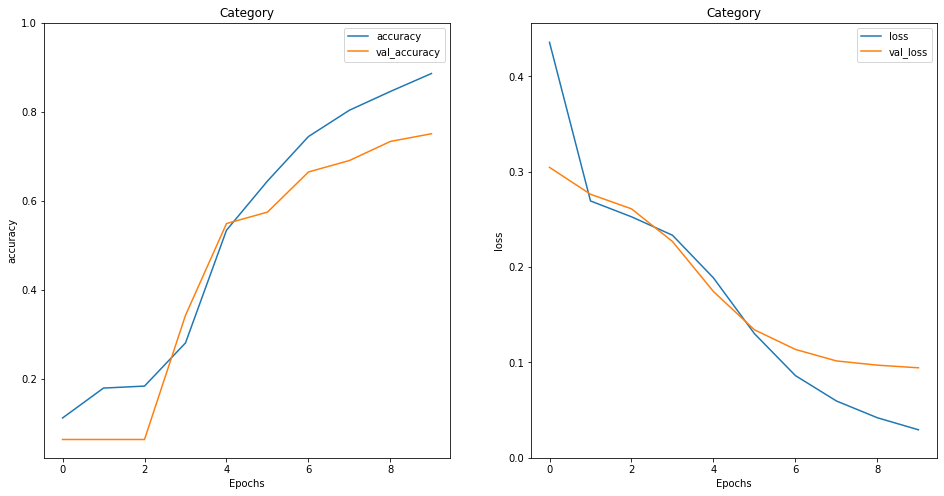

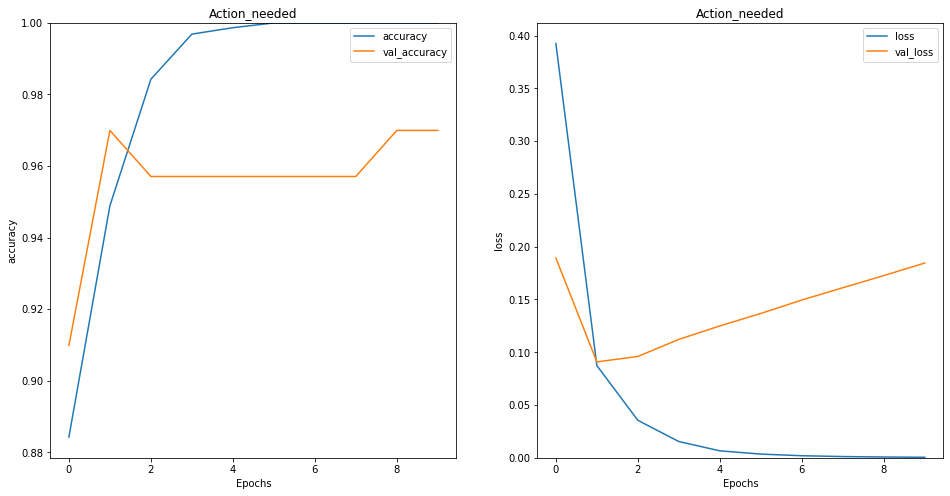

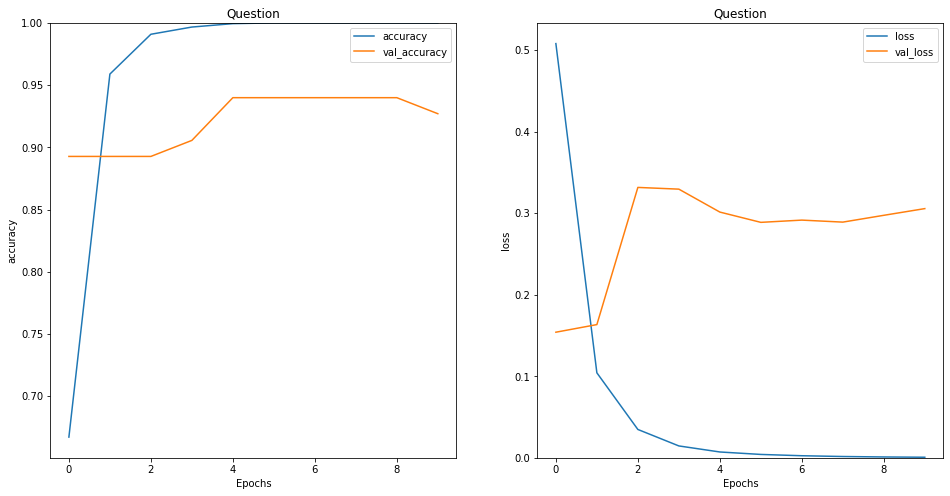

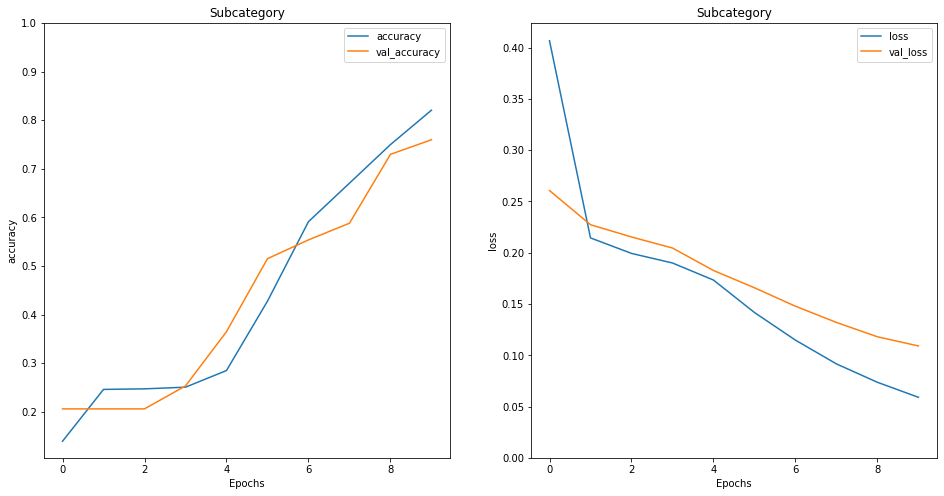

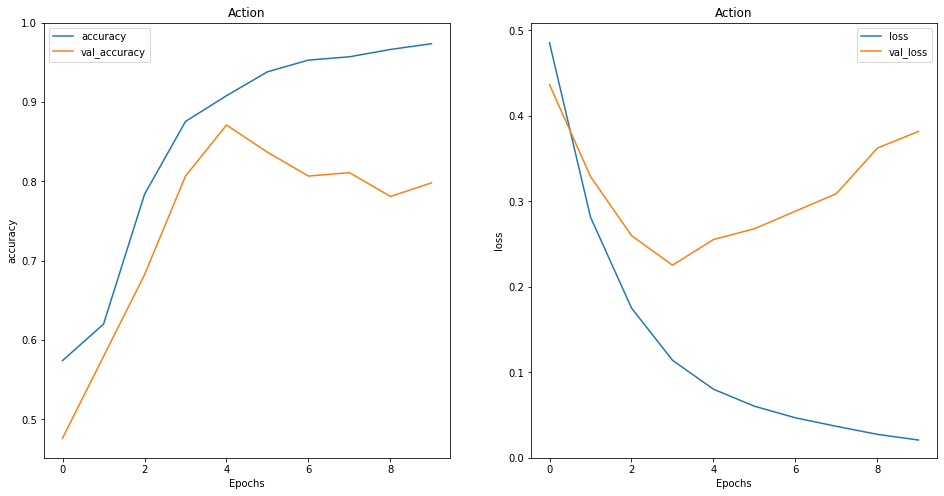

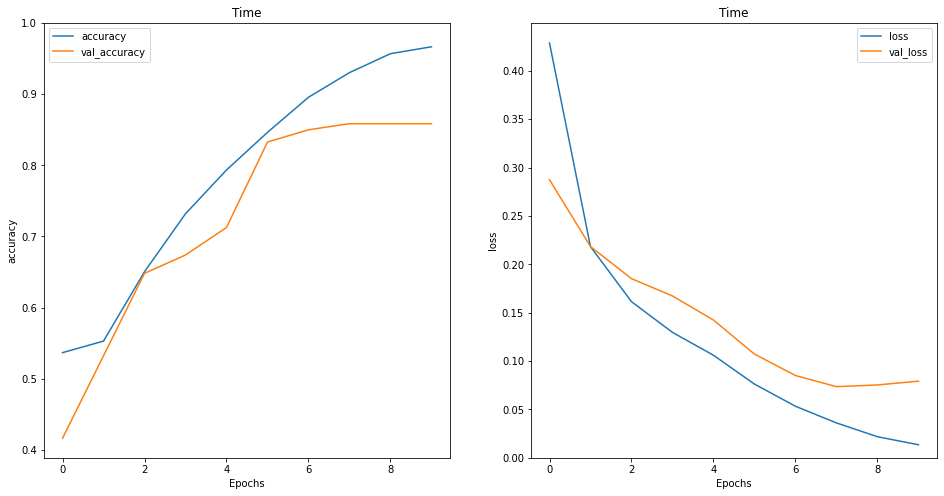

In [55]:
for c in ALL_COLS:
  plt.figure(figsize=(16, 8))

  plt.subplot(1, 2, 1)
  plt.title(c)
  plot_graphs(history[c], 'accuracy')
  plt.ylim(None, 1)

  plt.subplot(1, 2, 2)
  plt.title(c)
  plot_graphs(history[c], 'loss')
  plt.ylim(0, None)

  print()

In [56]:
mlp_max_iter_model_cat = MLPClassifier(max_iter=10000)
mlp_max_iter_model_cat = train_fit("MLPClassifier category", mlp_max_iter_model_cat, X_train_cat, y_train_cat, X_test_cat, y_test_cat)
mlp_max_iter_model_subcat = MLPClassifier(max_iter=10000)
mlp_max_iter_model_subcat = train_fit("MLPClassifier subcategory", mlp_max_iter_model_subcat, X_train_subcat, y_train_subcat, X_test_subcat, y_test_subcat)
mlp_max_iter_model_action = MLPClassifier(max_iter=10000)
mlp_max_iter_model_action = train_fit("MLPClassifier action", mlp_max_iter_model_action, X_train_action, y_train_action, X_test_action, y_test_action)
mlp_max_iter_model_action_needed = MLPClassifier(max_iter=10000)
mlp_max_iter_model_action_needed = train_fit("MLPClassifier action needed", mlp_max_iter_model_action_needed, X_train_action_needed, y_train_action_needed, X_test_action_needed, y_test_action_needed)
mlp_max_iter_model_question = MLPClassifier(max_iter=10000)
mlp_max_iter_model_question = train_fit("MLPClassifier question", mlp_max_iter_model_question, X_train_question, y_train_question, X_test_question, y_test_question)
mlp_max_iter_model_time = MLPClassifier(max_iter=10000)
mlp_max_iter_model_time = train_fit("MLPClassifier time", mlp_max_iter_model_time, X_train_time, y_train_time, X_test_time, y_test_time)

MLPClassifier category: 0.9156626506024096
MLPClassifier subcategory: 0.8674698795180723
MLPClassifier action: 0.8975903614457831
MLPClassifier action needed: 0.9216867469879518
MLPClassifier question: 0.9698795180722891
MLPClassifier time: 0.8554216867469879


In [57]:
sentence = "Hi Google, please turn off the lights."
print(sentence)

print("MLP:")
print("Category: ", predict(mlp_max_iter_model, uniquecategories, sentence))
print("Subcategory: ", predict(mlp_max_iter_model_subcat, uniquesubcategories, sentence))
print("Action: ", predict(mlp_max_iter_model_action, uniqueactions, sentence))
print("Action Needed: ", predict(mlp_max_iter_model_action_needed, uniqueaction_needed, sentence))
print("Question: ", predict(mlp_max_iter_model_question, uniquequestion, sentence))
print("Time: ", predict(mlp_max_iter_model_time, uniquetime, sentence))

print()

print("RNN:")
index = tf.argmax(model_rnn["Category"].predict(np.array([sentence])), axis=1)
print("Category: ", le["Category"].inverse_transform(index)[0])
answ = model_rnn["Question"].predict(np.array([sentence]))[0][0]
print("Question: ", 1 if answ >= 0 else 0)

Hi Google, please turn off the lights.
MLP:
Category:  lights
Subcategory:  none
Action:  off
Action Needed:  1
Question:  0
Time:  now

RNN:
Category:  lights
Question:  1


In [58]:
sentence = "Turn the lights off in the kitchen."
print(sentence)

print("MLP:")
print("Category: ", predict(mlp_max_iter_model, uniquecategories, sentence))
print("Subcategory: ", predict(mlp_max_iter_model_subcat, uniquesubcategories, sentence))
print("Action: ", predict(mlp_max_iter_model_action, uniqueactions, sentence))
print("Action Needed: ", predict(mlp_max_iter_model_action_needed, uniqueaction_needed, sentence))
print("Question: ", predict(mlp_max_iter_model_question, uniquequestion, sentence))
print("Time: ", predict(mlp_max_iter_model_time, uniquetime, sentence))

print()

print("RNN:")
for c in ALL_COLS:
  if df[c].max() == 1:
    answ = model_rnn[c].predict(np.array([sentence]))[0][0]
    print(c, ": ", 1 if answ >= 0 else 0)
  else:
    index = tf.argmax(model_rnn[c].predict(np.array([sentence])), axis=1)
    print(c, ": ", le[c].inverse_transform(index)[0])

Turn the lights off in the kitchen.
MLP:
Category:  lights
Subcategory:  kitchen
Action:  off
Action Needed:  1
Question:  0
Time:  now

RNN:
Category :  lights
Action_needed :  0
Question :  1
Subcategory :  kitchen
Action :  off
Time :  now


In [59]:
sentence = "Random sentence."
print(sentence)

print("MLP:")
print("Category: ", predict(mlp_max_iter_model, uniquecategories, sentence))
print("Subcategory: ", predict(mlp_max_iter_model_subcat, uniquesubcategories, sentence))
print("Action: ", predict(mlp_max_iter_model_action, uniqueactions, sentence))
print("Action Needed: ", predict(mlp_max_iter_model_action_needed, uniqueaction_needed, sentence))
print("Question: ", predict(mlp_max_iter_model_question, uniquequestion, sentence))
print("Time: ", predict(mlp_max_iter_model_time, uniquetime, sentence))

print()

print("RNN:")
for c in ALL_COLS:
  if df[c].max() == 1:
    answ = model_rnn[c].predict(np.array([sentence]))[0][0]
    print(c, ": ", 1 if answ >= 0 else 0)
  else:
    index = tf.argmax(model_rnn[c].predict(np.array([sentence])), axis=1)
    print(c, ": ", le[c].inverse_transform(index)[0])

Random sentence.
MLP:
Category:  other
Subcategory:  none
Action:  none
Action Needed:  0
Question:  0
Time:  none

RNN:
Category :  other
Action_needed :  1
Question :  1
Subcategory :  none
Action :  none
Time :  none


In [60]:
sentence = "Find the furthest bus stop."
print(sentence)

print("MLP:")
print("Category: ", predict(mlp_max_iter_model, uniquecategories, sentence))
print("Subcategory: ", predict(mlp_max_iter_model_subcat, uniquesubcategories, sentence))
print("Action: ", predict(mlp_max_iter_model_action, uniqueactions, sentence))
print("Action Needed: ", predict(mlp_max_iter_model_action_needed, uniqueaction_needed, sentence))
print("Question: ", predict(mlp_max_iter_model_question, uniquequestion, sentence))
print("Time: ", predict(mlp_max_iter_model_time, uniquetime, sentence))

print()

print("RNN:")
for c in ALL_COLS:
  if df[c].max() == 1:
    answ = model_rnn[c].predict(np.array([sentence]))[0][0]
    print(c, ": ", 1 if answ >= 0 else 0)
  else:
    index = tf.argmax(model_rnn[c].predict(np.array([sentence])), axis=1)
    print(c, ": ", le[c].inverse_transform(index)[0])

Find the furthest bus stop.
MLP:
Category:  direction
Subcategory:  myplace
Action:  none
Action Needed:  1
Question:  0
Time:  now

RNN:
Category :  direction
Action_needed :  0
Question :  1
Subcategory :  myplace
Action :  none
Time :  now


In [61]:
sentence = "Lower the door."
print(sentence)

print("MLP:")
print("Category: ", predict(mlp_max_iter_model, uniquecategories, sentence))
print("Subcategory: ", predict(mlp_max_iter_model_subcat, uniquesubcategories, sentence))
print("Action: ", predict(mlp_max_iter_model_action, uniqueactions, sentence))
print("Action Needed: ", predict(mlp_max_iter_model_action_needed, uniqueaction_needed, sentence))
print("Question: ", predict(mlp_max_iter_model_question, uniquequestion, sentence))
print("Time: ", predict(mlp_max_iter_model_time, uniquetime, sentence))

print()

print("RNN:")
for c in ALL_COLS:
  if df[c].max() == 1:
    answ = model_rnn[c].predict(np.array([sentence]))[0][0]
    print(c, ": ", 1 if answ >= 0 else 0)
  else:
    index = tf.argmax(model_rnn[c].predict(np.array([sentence])), axis=1)
    print(c, ": ", le[c].inverse_transform(index)[0])

Lower the door.
MLP:
Category:  shutters
Subcategory:  garage
Action:  down
Action Needed:  1
Question:  0
Time:  now

RNN:
Category :  garagedoor
Action_needed :  0
Question :  1
Subcategory :  garage
Action :  down
Time :  now


In [62]:
sentence = "How far am I from home?"
print(sentence)

print("MLP:")
print("Category: ", predict(mlp_max_iter_model, uniquecategories, sentence))
print("Subcategory: ", predict(mlp_max_iter_model_subcat, uniquesubcategories, sentence))
print("Action: ", predict(mlp_max_iter_model_action, uniqueactions, sentence))
print("Action Needed: ", predict(mlp_max_iter_model_action_needed, uniqueaction_needed, sentence))
print("Question: ", predict(mlp_max_iter_model_question, uniquequestion, sentence))
print("Time: ", predict(mlp_max_iter_model_time, uniquetime, sentence))

print()

print("RNN:")
for c in ALL_COLS:
  if df[c].max() == 1:
    answ = model_rnn[c].predict(np.array([sentence]))[0][0]
    print(c, ": ", 1 if answ >= 0 else 0)
  else:
    index = tf.argmax(model_rnn[c].predict(np.array([sentence])), axis=1)
    print(c, ": ", le[c].inverse_transform(index)[0])

How far am I from home?
MLP:
Category:  direction
Subcategory:  home
Action:  none
Action Needed:  1
Question:  1
Time:  now

RNN:
Category :  direction
Action_needed :  0
Question :  0
Subcategory :  home
Action :  none
Time :  now


In [63]:
sentence = "Stop."
print(sentence)

print("MLP:")
print("Category: ", predict(mlp_max_iter_model, uniquecategories, sentence))
print("Subcategory: ", predict(mlp_max_iter_model_subcat, uniquesubcategories, sentence))
print("Action: ", predict(mlp_max_iter_model_action, uniqueactions, sentence))
print("Action Needed: ", predict(mlp_max_iter_model_action_needed, uniqueaction_needed, sentence))
print("Question: ", predict(mlp_max_iter_model_question, uniquequestion, sentence))
print("Time: ", predict(mlp_max_iter_model_time, uniquetime, sentence))

print()

print("RNN:")
for c in ALL_COLS:
  if df[c].max() == 1:
    answ = model_rnn[c].predict(np.array([sentence]))[0][0]
    print(c, ": ", 1 if answ >= 0 else 0)
  else:
    index = tf.argmax(model_rnn[c].predict(np.array([sentence])), axis=1)
    print(c, ": ", le[c].inverse_transform(index)[0])

Stop.
MLP:
Category:  direction
Subcategory:  myplace
Action:  none
Action Needed:  1
Question:  0
Time:  now

RNN:
Category :  other
Action_needed :  0
Question :  1
Subcategory :  myplace
Action :  none
Time :  now


In [64]:
#42
sentence = "What is the meaning of life?"
print(sentence)

print("MLP:")
print("Category: ", predict(mlp_max_iter_model, uniquecategories, sentence))
print("Subcategory: ", predict(mlp_max_iter_model_subcat, uniquesubcategories, sentence))
print("Action: ", predict(mlp_max_iter_model_action, uniqueactions, sentence))
print("Action Needed: ", predict(mlp_max_iter_model_action_needed, uniqueaction_needed, sentence))
print("Question: ", predict(mlp_max_iter_model_question, uniquequestion, sentence))
print("Time: ", predict(mlp_max_iter_model_time, uniquetime, sentence))

print()

print("RNN:")
for c in ALL_COLS:
  if df[c].max() == 1:
    answ = model_rnn[c].predict(np.array([sentence]))[0][0]
    print(c, ": ", 1 if answ >= 0 else 0)
  else:
    index = tf.argmax(model_rnn[c].predict(np.array([sentence])), axis=1)
    print(c, ": ", le[c].inverse_transform(index)[0])

What is the meaning of life?
MLP:
Category:  other
Subcategory:  none
Action:  none
Action Needed:  0
Question:  0
Time:  none

RNN:
Category :  other
Action_needed :  1
Question :  1
Subcategory :  none
Action :  none
Time :  none


Looks like I overfitted the boolean ones in the RNN. And the category one could use a bit more training, but it still works.